In [1]:
%matplotlib inline
import cv2
import imutils
import os
from matplotlib import pyplot as plt

def cv2_imshow(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [2]:
os.chdir("sample-images")

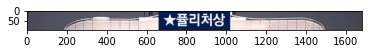

In [3]:
src = cv2.imread("sample10.png")
height, width, channels = src.shape
img = src[int(height*0.85):int(height*0.95)].copy()
cv2_imshow(img)

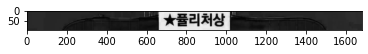

In [4]:
# Convert from BGR to HSV color space
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Get the saturation plane - all black/white/gray pixels are zero, and colored pixels are above zero.
s = hsv[:, :, 1]

cv2_imshow(s)

In [5]:
x_pad_off = 8

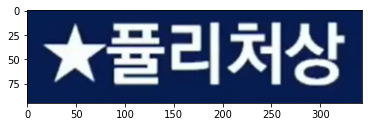

In [6]:
# Apply threshold on s - use automatic threshold algorithm (use THRESH_OTSU).
ret, thresh = cv2.threshold(s, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Find contours
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cnts = imutils.grab_contours(cnts) 

# Find the contour with the maximum area.
c = max(cnts, key=cv2.contourArea)

# Get bounding rectangle
x, y, w, h = cv2.boundingRect(c)

# Crop the bounding rectangle out of img
out = img[y:y+h, x+x_pad_off:x+w-x_pad_off, :].copy()

cv2_imshow(out)

In [7]:
# domient 색깔 감지
import numpy as np

colors, count = np.unique(out.reshape(-1,out.shape[-1]), axis=0, return_counts=True)
b, g, r = colors[count.argmax()]
r, g, b

(6, 29, 81)

In [8]:
# 파란색이면 성공
(r, g, b) == (10, 28, 77)

False

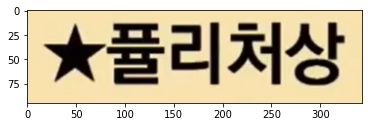

In [9]:
# Invert Image
out_i = cv2.bitwise_not(out)
cv2_imshow(out_i)

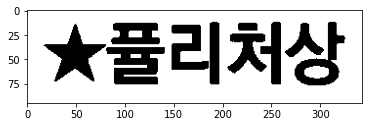

In [10]:
# 인식 가능하도록 흑/백 값으로 변환
# out_r = cv2.resize(out_i, None, fx=1.8, fy=1.8, interpolation=cv2.INTER_CUBIC+cv2.INTER_LINEAR)
out_g = cv2.cvtColor(out_i, cv2.COLOR_BGR2GRAY)
ret, out_th = cv2.threshold(out_g, 150, 255, cv2.THRESH_BINARY)
cv2_imshow(out_th)

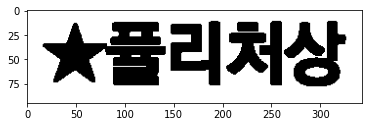

In [11]:
kernel = np.ones((3,3), np.uint8)
out_er = cv2.erode(out_th, kernel, iterations = 1)
out_erinv = out_er
cv2_imshow(out_erinv)

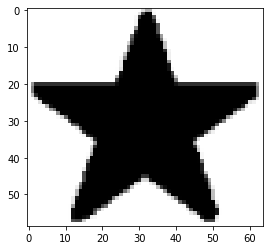

In [12]:
# 앞에 있는 별표 삭제
# https://stackoverflow.com/questions/58019027/finding-an-image-inside-of-an-image-using-cv2

# 1. 별표 sample.png 를 불러오기
star_sample = cv2.imread('search.png', 0)
cv2_imshow(star_sample)

In [13]:
w, h = star_sample.shape[::-1]
roi_start = (430, 550) # top left corner of the selected area
roi_end = (526,651) # bottom right corner of the selected area

test_img = out_erinv.copy()

roi = out_erinv[roi_start[1]: roi_end[1], roi_start[0]: roi_end[0]]
res = cv2.matchTemplate(out_erinv, star_sample, cv2.TM_CCOEFF_NORMED)
threshold = 0.7
loc = np.where(res >= threshold)
for pt in zip(*loc[::-1]):
    if pt is not None:
        print("character found")
        cv2.rectangle(test_img, pt, (pt[0]+w, pt[1]+h), (0,255,255), 2)
        break

character found


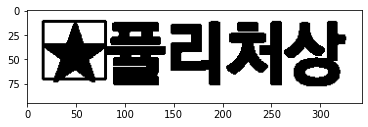

In [14]:
cv2_imshow(test_img)

In [15]:
loc

(array([11, 11, 11, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15,
        16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18,
        18, 18, 18]),
 array([16, 17, 18, 14, 15, 16, 17, 18, 19, 13, 14, 15, 16, 17, 18, 19, 20,
        13, 14, 15, 16, 17, 18, 19, 20, 21, 13, 14, 15, 16, 17, 18, 19, 20,
        14, 15, 16, 17, 18, 19, 20, 14, 15, 16, 17, 18, 19, 20, 14, 15, 16,
        17, 18, 19]))

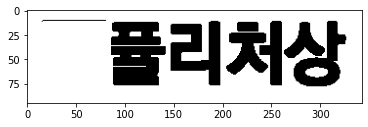

In [16]:
# Remove rectangle (by filling inside)
background = [0, 0, 0]
for pt in zip(*loc[::-1]):
    if pt is not None:
#         print("character found")
#         print(pt)
        cv2.rectangle(test_img, pt, (pt[0]+w, pt[1]+h), (255,255,255), -1)
cv2_imshow(test_img)

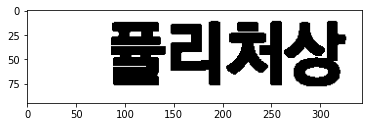

In [17]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
morph = cv2.morphologyEx(test_img, cv2.MORPH_CLOSE, kernel)
cv2_imshow(morph)

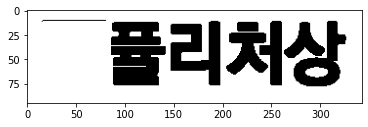

In [18]:
cv2_imshow(test_img)

단어: '플리처상'


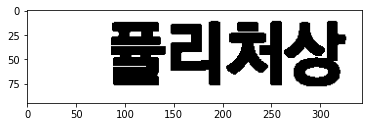

In [19]:
import pytesseract
# out_rgb = cv2.cvtColor(out_erinv, cv2.COLOR_BGR2RGB)
target_img = morph.copy()
result = pytesseract.image_to_string(target_img, config="--psm 6", lang='kor')
print("단어: '%s'" % result.strip())
cv2_imshow(target_img)